# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Explore and clean the portfolio data**

In [5]:
#check content of the portfolio data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
#check the size/shape
portfolio.shape

(10, 6)

get different channels in the channels colums 

In [7]:

# check the channels
from collections import deque
channels = deque([])
for channel in portfolio.channels:
    for chan in channel:
        try:
            channels.index(chan)
        except ValueError:
            channels.append(chan)
print(channels)

deque(['email', 'mobile', 'social', 'web'])


Create a dummy variable for each channel and drop the channels column

In [8]:
#create a seperate column for each channel with 1 0r 0 depending if the channel was used

for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x :1 if channel in x else 0)

portfolio.drop('channels', inplace = True, axis = 1)
    

Now lets look at the offer_types in the offer_type column

In [9]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

offer type has 4 different offers, lets create a dummy variable for each and drop the original offer type

In [10]:
portfolio = pd.concat([portfolio,pd.get_dummies(portfolio['offer_type'])], axis = 1).drop(['offer_type'], axis =1)

In [11]:
#rename id to offer id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [12]:
#check what porfolio looks like after the cleaning
portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


# Explore profile data

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.shape

(17000, 5)

In [15]:
#check the number of missing data in profile
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

From the above, it shows that 2175 of 17000. data for both gender and income is missing. these rows will be dropped 

In [16]:
profile.dropna(inplace = True) 

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

the gender column has 3 categories, we will create a dummy variable for each and drop the original gender column

In [18]:
#create dummy variables fopr gender and drop the gender column
profile = pd.concat([profile,pd.get_dummies(profile['gender'],  prefix='Gender', prefix_sep='_')],
                    axis = 1).drop('gender', axis = 1)

Now to the 'became_member_on' column, we will calculate the number of days each customer has been a member by subtracting the became_member_on date from today's date and name it 'member_days' and drop the became_member_on column

In [19]:
today = datetime.date.today()
profile['member_days']= (today -  pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days

In [20]:
profile.drop('became_member_on', axis = 1, inplace=True)

Lets take a look at the distribution of some data like age, member_days and income 

Text(0.5, 0, 'Income')

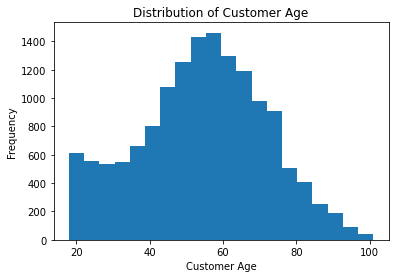

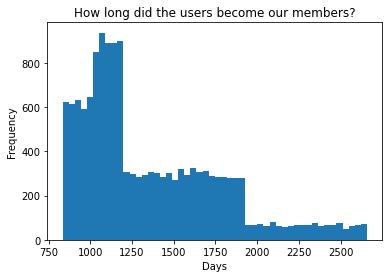

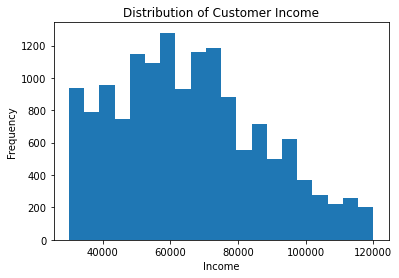

In [21]:

# Display Histogram of Customer Age
user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age');
user_age.set_xlabel("Customer Age")

# Display Histogram of the days being member
plt.figure()
memberdays = profile['member_days'].plot(kind='hist', bins=50, title='How long did the users become our members?');
memberdays.set_xlabel("Days")

# Display Histogram of User Income
plt.figure()
user_income = profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income');
user_income.set_xlabel("Income")

From the distribution of Age graph above, it shows the highest number of ages in the data are between 50-60, theres also large amount of data for ages between 45-60 and 60-75 thereabout

For the distribution of member days, most of the customer in the data joined 1050-1200 days, theres also a large number of customer that have joined around 800-1050 days, some are distributed among 1200-1900days while others are old members that have joined for about 1900-3000 days


From the distribution of Customer Income, it shows that highest number of customers(1300) in the data earns around 55000- 60000, and few numbers of about 200 earns 110000-120000.. the highest earning is 120000

In [22]:
#rename the id column to customer id
profile.rename(columns={"id":"customer_id"}, inplace= True)
profile.head()

,age,customer_id,income,Gender_F,Gender_M,Gender_O,member_days
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1210
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1277
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,925
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,1001
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,1091


Now, lets see the age by income distibution and draw somw analysis from it

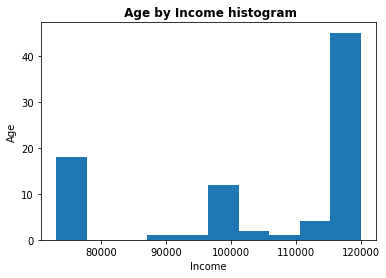

In [23]:
plt.hist(profile.groupby('age')['income'].max());
plt.xlabel('Income') 
plt.ylabel('Age') 
  
plt.title(' Age by Income histogram', 
          fontweight ="bold");

From the above graph, it shows customer that earns between 115000-120000 are above the age of 40, those that earn below 80000 are below the age of 20, theres some that are below the age of 20 and earns 90000-115000.


**Explore transcript data**

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
# transcript size/shape
transcript.shape

(306534, 4)

In [26]:
# check number of missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

transcript data set has no missing values

In [27]:
# check transcript descrption
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [28]:
# check transcript information
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Extract data from the transcript['value'], put key in a column called event_type and the value in another column event_id

In [29]:
def extract_dict(dict_):
    '''
    input : A dictionary 
    
    output: A tuple of the first item n the dictionary(key and value)
    '''

    for k,v in dict_.items():
        return(k,v)
    


transcript['event_type'] = transcript['value'].apply(lambda x: extract_dict(x)[0])
transcript['event_id'] = transcript['value'].apply(lambda x: extract_dict(x)[1])


In [30]:
# drop the values
transcript.drop('value', inplace=True , axis= 1)

check for the unique vaues in the new column 'event type' created from the above

In [31]:
transcript.event_type.unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

offer_id seem to be represented with two values, 'offer_id' and 'offer id'. replace all offer id with 'offer_id'


In [32]:
transcript['event_type'] = transcript['event_type'].apply(lambda x: 'offer_id' if 'offer'in x else x )

check the new unique values in event_type

In [33]:
transcript['event_type'].unique()

array(['offer_id', 'amount'], dtype=object)

In [34]:
#rename person column to person_id
transcript.rename(columns={"person": "customer_id"}, inplace=True)

check the unique values in event  

In [35]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [36]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The graph below shows the distribution of events in the dataset, transaction has a higher number of data here.
Transactions: shows transactions made by customers that did not recieve any offer but made transaction anyway
offer received: shows the number of offers that was sent and received by the customers
offer viewed : shows the number of offers that was viewed by the customers
offer completed : shows the number of offers that were completed by the customers

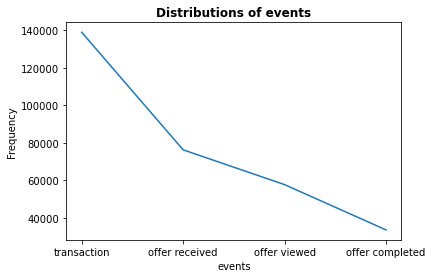

In [37]:
plt.plot(transcript['event'].value_counts());
plt.xlabel('events') 
plt.ylabel('Frequency') 
  
plt.title('Distributions of events', 
          fontweight ="bold");

µn

In [38]:
#drop rows with event 'transaction'
transcript.drop(transcript[transcript['event'] == 'transaction'].index, inplace=True)

#get dummies for the event categories left
offer_dummies = pd.get_dummies(transcript['event'])

Since we are trying to determine which customer will complete an offer or not, we ll be using just the offer_recieved dummies to create a new transcript df which will be used for training

In [39]:
new_transcript = pd.concat([transcript , offer_dummies['offer completed']], axis =1).drop('event', axis =1)

In [40]:
new_transcript.head()

,customer_id,time,event_type,event_id,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,0,offer_id,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer_id,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,0,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [42]:
new_transcript.shape

(167581, 5)

drop the event_type , since all event is now an offer
then, rename the event_id to offer_id

In [43]:
new_transcript.drop('event_type', axis = 1, inplace= True)
new_transcript.rename(columns={"event_id":"offer_id"}, inplace=True)

In [44]:
new_transcript.head()

,customer_id,time,offer_id,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


Merge profile dataset and new_transcript data on the customer_id 

In [45]:
profile_transcript_df = pd.merge(profile,new_transcript,on ='customer_id')

In [46]:
profile_transcript_df.head()

,age,customer_id,income,Gender_F,Gender_M,Gender_O,member_days,time,offer_id,offer completed
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1210,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1210,504,3f207df678b143eea3cee63160fa8bed,0
2,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1210,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1277,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
4,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1277,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0


Merge profile transcript_df with portfolio on offer id

In [47]:
final_df = pd.merge(portfolio ,profile_transcript_df, on ='offer_id')

drop customer id and offer id  and time as its not need for the machine learning model

In [48]:
final_df.drop(['customer_id', 'offer_id', 'time'], axis =1, inplace=True)

In [49]:
final_df.head()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,Gender_F,Gender_M,Gender_O,member_days,offer completed
0,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277,0
1,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277,0
2,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277,1
3,10,10,7,1,1,1,0,1,0,0,61,57000.0,1,0,0,1152,0
4,10,10,7,1,1,1,0,1,0,0,61,57000.0,1,0,0,1152,1


In [50]:
final_df.shape

(148805, 17)

In [51]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   reward           148805 non-null  int64  
 1   difficulty       148805 non-null  int64  
 2   duration         148805 non-null  int64  
 3   email            148805 non-null  int64  
 4   mobile           148805 non-null  int64  
 5   social           148805 non-null  int64  
 6   web              148805 non-null  int64  
 7   bogo             148805 non-null  uint8  
 8   discount         148805 non-null  uint8  
 9   informational    148805 non-null  uint8  
 10  age              148805 non-null  int64  
 11  income           148805 non-null  float64
 12  Gender_F         148805 non-null  uint8  
 13  Gender_M         148805 non-null  uint8  
 14  Gender_O         148805 non-null  uint8  
 15  member_days      148805 non-null  int64  
 16  offer completed  148805 non-null  uint

In [52]:
final_df.describe()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,Gender_F,Gender_M,Gender_O,member_days,offer completed
count,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,4.442445,7.890561,6.625207,1.0,0.917160,0.658311,0.806747,0.428978,0.418743,0.152280,54.779282,66414.119149,0.428205,0.557078,0.014717,1372.130634,0.218030
std,3.372362,5.041335,2.133035,0.0,0.275641,0.474277,0.394851,0.494932,0.493355,0.359293,17.193533,21496.947967,0.494820,0.496733,0.120419,415.347166,0.412909
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,834.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,43.000000,51000.000000,0.000000,0.000000,0.000000,1055.000000,0.000000
50%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,56.000000,65000.000000,0.000000,1.000000,0.000000,1228.000000,0.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,67.000000,81000.000000,1.000000,1.000000,0.000000,1650.000000,0.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,120000.000000,1.000000,1.000000,1.000000,2657.000000,1.000000


**Machine Learning section**

import necessary libraries for the the training


Here, I am going to build a model that predicts whether or not someone will complete to an offer or not 

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score

create variable X and y where X is the Independent variable and y is the dependent variable(outcome)

In [54]:
X = final_df.drop(['offer completed'],axis = 1)
y = final_df['offer completed']

In [55]:
X.head()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,Gender_F,Gender_M,Gender_O,member_days
0,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277
1,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277
2,10,10,7,1,1,1,0,1,0,0,75,100000.0,1,0,0,1277
3,10,10,7,1,1,1,0,1,0,0,61,57000.0,1,0,0,1152
4,10,10,7,1,1,1,0,1,0,0,61,57000.0,1,0,0,1152


In [56]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: offer completed, dtype: uint8

We will be trying out 3 classifers, svm, kNeigbours, DecisionTree

In [57]:
svm_pipeline = Pipeline([

    ('clf', svm.SVC())
])

knn_pipeline = Pipeline([
    ('clf',KNeighborsClassifier() )
])


dt_pipeline = Pipeline([
    ('clf', DecisionTreeClassifier() )
])


we will also use gridserach fo find the best parameters for the classifiers

In [58]:
# knn_pipeline.get_params()

In [59]:
# svm
svm_params={
        'clf__degree': (2,3,4),
        'clf__max_iter': (-1,-2),
        'verbose':(True, False)
        }

# knn
knn_params={
        'clf__n_neighbors': (5,6,7),
        'clf__leaf_size': (30,40),
        'verbose':(True, False)
        }



#DecisionTreeClassifier

dt_params={
        'clf__min_samples_leaf': [1,2],
         'clf__min_samples_split': [2,4],
        }


svm_cv = GridSearchCV(svm_pipeline, param_grid=svm_params)
knn_cv = GridSearchCV(knn_pipeline, param_grid=knn_params)
dt_cv = GridSearchCV(dt_pipeline, param_grid=dt_params)


split X and Y into train and test set

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.3)

Feature scaling is introduced because we have columns in x like the income and member days with large data values, with feature scaling we can scales the large value to less values to make the training results more accurate

In [116]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [122]:
svm_model = svm_cv.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 1) Processing clf, total= 5.1min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.0min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.8min


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.1s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.2min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.7min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.8min


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.3min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 4.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.9min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.7min
[Pipeline] ............... (step 1 of 1) Processing clf, total= 3.7min


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with S

[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.0s


/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/muneerah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=-2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[Pipeline] ............... (step 1 of 1) Processing clf, total= 5.7min


In [118]:
knn_model = knn_cv.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 1) Processing clf, total=  15.6s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.3s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.3s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.4s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  15.3s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.6s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.1s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  15.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.1s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.7s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.5s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.7s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  15.0s
[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.9s
[Pipel

In [126]:
dt_model = dt_cv.fit(X_train, y_train)

In [145]:
print(svm_cv.best_params_ )
# print(knn_cv.best_params_)
print(dt_cv.best_params_)

{'clf__degree': 2, 'clf__max_iter': -1, 'verbose': True}
{'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}


In [129]:
svm_y_pred = svm_model.predict(X_test)
knn_y_pred = knn_model.predict(X_test)
dt_y_pred = dt_model.predict(X_test)

In [139]:
def evaluate_model(model, y_pred,y_test=y_test):
    '''
      INPUT - model : a defined model pipeline
              X_test: test set of the independent variables (messages)
              Y_test: test set of the dependent variables (categories)
      '''
    
    
    print('confusion_matrix:\n',confusion_matrix(y_test,y_pred))
    print('accuracy_score:\n',accuracy_score(y_test,y_pred), '\n')

In [140]:
evaluate_model(svm_model,svm_y_pred)
evaluate_model(knn_model, knn_y_pred)
evaluate_model(dt_model,dt_y_pred)

confusion_matrix:
 [[34929     0]
 [ 9713     0]]
accuracy_score:
 0.782424622552753 

confusion_matrix:
 [[34434   495]
 [ 9681    32]]
accuracy_score:
 0.7720532234218896 

confusion_matrix:
 [[30874  4055]
 [ 9576   137]]
accuracy_score:
 0.6946597374669594 

